# Overlays, markers and annotations

(… plot-generation might take a bit longer since overlays need to be downloaded first!)

- add basic overlays with `m.add_overlay`
- add static annotations / markers with `m.add_annotation` and `m.add_marker`
- use “connected” Maps-objects to get multiple interactive data-layers!

![image](../../../_static/example_images/example_overlays.gif)

The data displayed in the above gif is taken from:
    - NaturalEarth (https://www.naturalearthdata.com/)

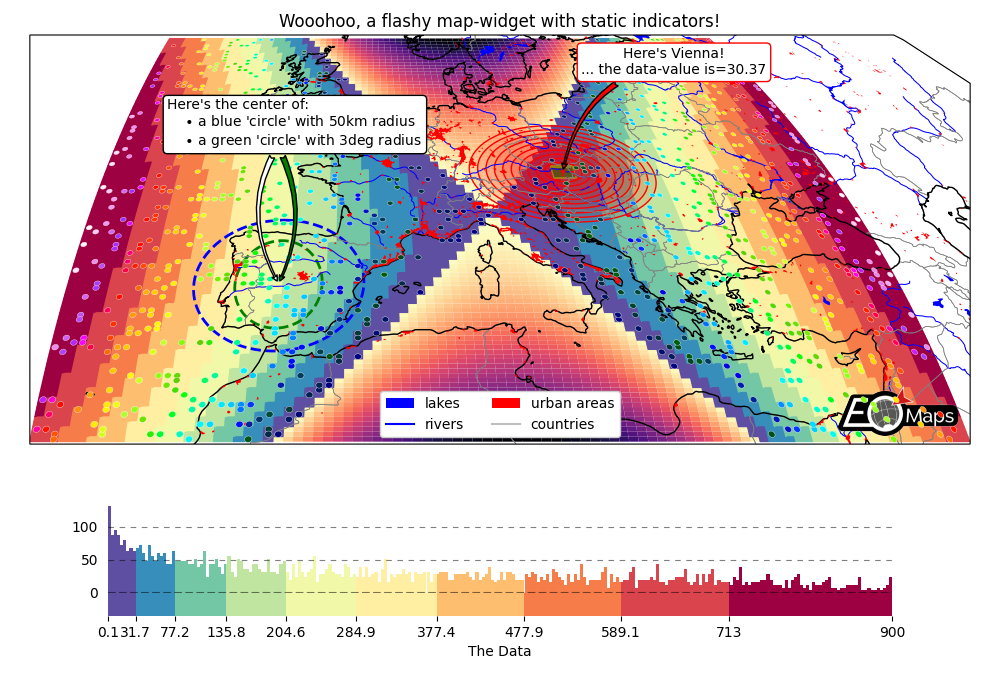

In [1]:
# EOmaps example: Add overlays and indicators

from eomaps import Maps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# create some data
lon, lat = np.meshgrid(np.linspace(-20, 40, 100), np.linspace(30, 60, 100))
data = pd.DataFrame(
    dict(
        lon=lon.flat,
        lat=lat.flat,
        param=(((lon - lon.mean()) ** 2 - (lat - lat.mean()) ** 2)).flat,
    )
)
data_OK = data[data.param >= 0]
data_OK.var = np.sqrt(data_OK.param)
data_mask = data[data.param < 0]

# --------- initialize a Maps object and plot the data
m = Maps(Maps.CRS.Orthographic(), figsize=(10, 7))
m.ax.set_title("Wooohoo, a flashy map-widget with static indicators!")
m.set_data(data=data_OK, x="lon", y="lat", crs=4326)
m.set_shape.rectangles(mesh=True)
m.set_classify_specs(scheme="Quantiles", k=10)
m.plot_map(cmap="Spectral_r")

# ... add an "annotate" callback
cid = m.cb.click.attach.annotate(bbox=dict(alpha=0.75, color="w"))

# - create a new layer and plot another dataset
m2 = m.new_layer()
m2.set_data(data=data_mask, x="lon", y="lat", crs=4326)
m2.set_shape.rectangles()
m2.plot_map(cmap="magma", set_extent=False)

# create a new layer for some dynamically updated data
m3 = m.new_layer()
m3.set_data(data=data_OK.sample(1000), x="lon", y="lat", crs=4326)
m3.set_shape.ellipses(radius=25000, radius_crs=3857)

# plot the map and set dynamic=True to allow continuous updates of the
# collection without re-drawing the background map
m3.plot_map(
    cmap="gist_ncar", edgecolor="w", linewidth=0.25, dynamic=True, set_extent=False
)


# define a callback that changes the values of the previously plotted dataset
# NOTE: this is not possible for the shapes:  "shade_points" and "shade_raster"!
def callback(m, **kwargs):
    # NOTE: Since we change the array of a dynamic collection, the changes will be
    # reverted as soon as the background is re-drawn (e.g. on pan/zoom events)
    selection = np.random.randint(0, len(m.data), 1000)
    m.coll.set_array(data_OK.param.iloc[selection])


# attach the callback (to update the dataset plotted on the Maps object "m3")
m.cb.click.attach(callback, m=m3, on_motion=True)

# --------- add some basic overlays from NaturalEarth
m.add_feature.preset.coastline()
m.add_feature.preset.lakes()
m.add_feature.preset.rivers_lake_centerlines()
m.add_feature.preset.countries()
m.add_feature.preset.urban_areas()

# add a customized legend
leg = m.ax.legend(
    [
        Patch(fc="b"),
        plt.Line2D([], [], c="b"),
        Patch(fc="r"),
        plt.Line2D([], [], c=".75"),
    ],
    ["lakes", "rivers", "urban areas", "countries"],
    ncol=2,
    loc="lower center",
    facecolor="w",
    framealpha=1,
)
# add the legend as artist to keep it on top
m.BM.add_artist(leg)

# --------- add some fancy (static) indicators for selected pixels
mark_id = 6060
for buffer in np.linspace(1, 5, 10):
    m.add_marker(
        ID=mark_id,
        shape="ellipses",
        radius="pixel",
        fc=(1, 0, 0, 0.1),
        ec="r",
        buffer=buffer * 5,
        n=100,  # use 100 points to represent the ellipses
    )
m.add_marker(
    ID=mark_id, shape="rectangles", radius="pixel", fc="g", ec="y", buffer=3, alpha=0.5
)
m.add_marker(
    ID=mark_id, shape="ellipses", radius="pixel", fc="k", ec="none", buffer=0.2
)
m.add_annotation(
    ID=mark_id,
    text=f"Here's Vienna!\n... the data-value is={m.data.param.loc[mark_id]:.2f}",
    xytext=(80, 70),
    textcoords="offset points",
    bbox=dict(boxstyle="round", fc="w", ec="r"),
    horizontalalignment="center",
    arrowprops=dict(arrowstyle="fancy", facecolor="r", connectionstyle="arc3,rad=0.35"),
)

mark_id = 3324
m.add_marker(ID=mark_id, shape="ellipses", radius=3, fc="none", ec="g", ls="--", lw=2)
m.add_annotation(
    ID=mark_id,
    text="",
    xytext=(0, 98),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="fancy", facecolor="g", connectionstyle="arc3,rad=-0.25"
    ),
)

m.add_marker(
    ID=mark_id,
    shape="geod_circles",
    radius=500000,
    radius_crs=3857,
    fc="none",
    ec="b",
    ls="--",
    lw=2,
)

m.add_annotation(
    ID=mark_id,
    text=(
        "Here's the center of:\n"
        + "    $\\bullet$ a blue 'circle' with 50km radius\n"
        + "    $\\bullet$ a green 'circle' with 3deg radius"
    ),
    xytext=(-80, 100),
    textcoords="offset points",
    bbox=dict(boxstyle="round", fc="w", ec="k"),
    horizontalalignment="left",
    arrowprops=dict(arrowstyle="fancy", facecolor="w", connectionstyle="arc3,rad=0.35"),
)

cb = m.add_colorbar(label="The Data", tick_precision=1)
m.add_logo()
m.show()